### Multi-Label Classification

In [1]:
from fastai.vision.all import *

In [ ]:
planet_source = untar_data(URLs.PLANET_SAMPLE)

In [ ]:
df = pd.read_csv(planet_source/'labels.csv')

In [ ]:
df.head()

In [ ]:
df = df[df['tags'] != 'blow_down clear primary road']

In [ ]:
batch_tfms = aug_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [ ]:
planet = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x=ColReader(0, pref=f'{planet_source}/train/', suff='.jpg'),
                   splitter=RandomSplitter(),
                   get_y=ColReader(1, label_delim=' '),
                   batch_tfms=batch_tfms
                  )

In [ ]:
dls = planet.dataloaders(df)

In [ ]:
dls.show_batch(max_n=9, figsize=(12, 9))

In [ ]:
learn = cnn_learner(dls, resnet34, pretrained=True, metrics=[accuracy_multi])

In [2]:
class BCEWithLogitsLossFlat(BaseLoss):
    @use_kwargs_dict(keep=True, weight=None, reduction='mean', pos_weight=None)
    def __init__(self, *args, axis=-1, floatify=True, thresh=0.5, **kwargs):
        if kwargs.get('pos_weight', None) is not None and kwargs.get('flatten') is True:
            raise ValueError(" ")
        if kwargs.get('pos_weight', None) is not None: kwargs['flatten'] = False
        super().__init__(nn.BCEWithLogitsLoss,*args, axis=axis,floatify=floatify,is_2d=False, **kwargs)
        self.thresh=thresh
        
    def decodes(self, x): return x>self.thresh
    def activation(self, x): return torch.sigmoid(x)

In [ ]:
learn.loss_func = BCEWithLogitsLossFlat()

In [ ]:
lr_valley = learn.lr_find(suggest_funcs=valley)

In [ ]:
learn = learn.to_fp16()

In [ ]:
learn.fit_one_cycle(5, lr_valley)

In [3]:
data_path = 'C:/Users/light/Documents/Fastbook/Personal-Machine-Learning-Data/'
#learn.save(data_path + '2_stage_1')

In [ ]:
learn.unfreeze()
lr_valley_2 = learn.lr_find(suggest_funcs=valley)

In [ ]:
learn.fit_one_cycle(5, lr_valley_2)

In [ ]:
learn.show_results(figsize=(15,15))

### Unknown Labels

In [4]:
from fastai.vision.all import *
import warnings
warnings.filterwarnings('ignore')

In [5]:
path = Path('C:/Users/light/Documents/Fastbook/Personal-Machine-Learning-Data/Fruit/')

In [6]:
item_tfms = RandomResizedCrop(460, min_scale=0.75)
batch_tfms = [*aug_transforms(size=224, max_warp=0), Normalize.from_stats(*imagenet_stats)]

In [7]:
fruits = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_items=get_image_files,
                   splitter=RandomSplitter(),
                   get_y=Pipeline([parent_label, lambda label: [label]]),
                   item_tfms=item_tfms,
                   batch_tfms=batch_tfms)

In [8]:
dls = fruits.dataloaders(path, num_workers=0)

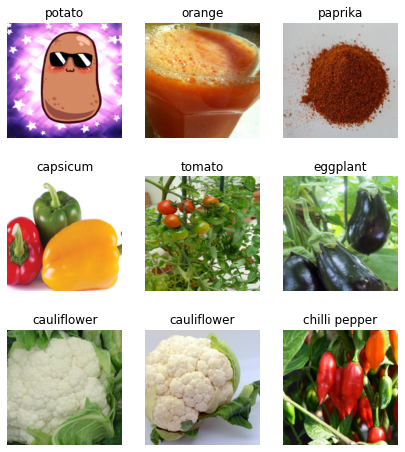

In [9]:
dls.show_batch(max_n=9,figsize=(7,8))

In [10]:
learn = cnn_learner(dls, resnet34, pretrained=True, metrics=[partial(accuracy_multi, thresh=0.95)], 
                    loss_func=BCEWithLogitsLossFlat(thresh=0.5)).to_fp16()

In [11]:
learn.fine_tune(16)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.924581,0.598070,0.978697,04:33


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.701430,0.519225,0.978697,04:14
1,0.603824,0.384998,0.978212,04:15
2,0.445094,0.185463,0.975816,04:33
3,0.264470,0.083024,0.974942,04:17
4,0.150704,0.054064,0.975751,04:11
5,0.093698,0.040939,0.977888,03:24
6,0.065024,0.034869,0.980575,03:14
7,0.048119,0.030750,0.982971,03:15
8,0.037998,0.028711,0.984784,03:13
9,0.031445,0.026699,0.985852,03:15


In [12]:
learn.save(data_path + 'fruits')

Path('C:/Users/light/Documents/Fastbook/Personal-Machine-Learning-Data/fruits.pth')

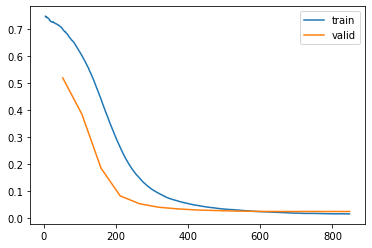

In [13]:
learn.recorder.plot_loss()

In [14]:
learn.loss_func=BCEWithLogitsLossFlat(thresh=0.5)

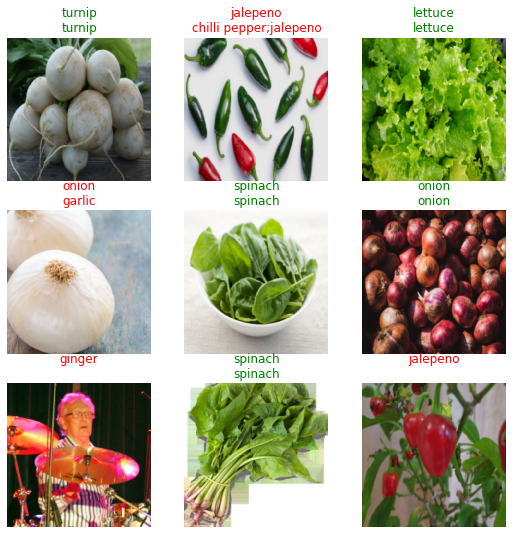

In [15]:
learn.show_results()

<AxesSubplot:>

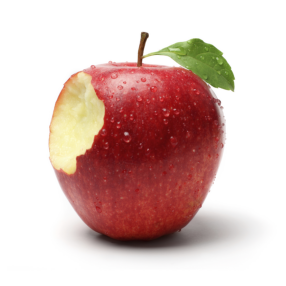

In [16]:
img = PILImage.create(data_path + 'Fruit/train/apple/Image_1.jpg')
img.show()

In [17]:
learn.predict(img)[0]

(#1) ['apple']

<AxesSubplot:>

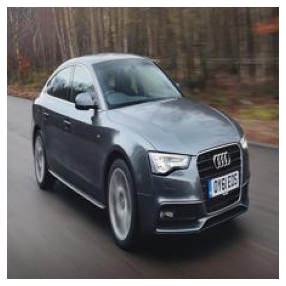

In [21]:
car_path = 'C:/Users/light/Documents/Fastbook/clean/cars/Audi/'
img = PILImage.create(car_path + '0000.jpg.png')
img.show()

In [22]:
learn.predict(img)[0]

(#0) []

### Cross-Validation

In [1]:
from fastai.vision.all import *

In [2]:
path = untar_data(URLs.IMAGEWOOF)

In [3]:
path.ls()

(#3) [Path('C:/Users/light/.fastai/data/imagewoof2/noisy_imagewoof.csv'),Path('C:/Users/light/.fastai/data/imagewoof2/train'),Path('C:/Users/light/.fastai/data/imagewoof2/val')]

In [4]:
item_tfms = [ToTensor(), RandomResizedCrop(460, min_scale=0.75, ratio=(1.,1.))]
batch_tfms = [IntToFloatTensor(), *aug_transforms(size=224, max_warp=0), Normalize.from_stats(*imagenet_stats)]
bs=32

In [5]:
train_imgs = get_image_files(path/'train')
tst_imgs = get_image_files(path/'val')

In [6]:
random.shuffle(train_imgs)

In [7]:
len(train_imgs)

9025

In [8]:
train_imgs

(#9025) [Path('C:/Users/light/.fastai/data/imagewoof2/train/n02087394/n02087394_3275.JPEG'),Path('C:/Users/light/.fastai/data/imagewoof2/train/n02105641/n02105641_8206.JPEG'),Path('C:/Users/light/.fastai/data/imagewoof2/train/n02105641/n02105641_8589.JPEG'),Path('C:/Users/light/.fastai/data/imagewoof2/train/n02099601/n02099601_9385.JPEG'),Path('C:/Users/light/.fastai/data/imagewoof2/train/n02115641/n02115641_1264.JPEG'),Path('C:/Users/light/.fastai/data/imagewoof2/train/n02093754/n02093754_514.JPEG'),Path('C:/Users/light/.fastai/data/imagewoof2/train/n02089973/n02089973_1277.JPEG'),Path('C:/Users/light/.fastai/data/imagewoof2/train/n02115641/n02115641_1817.JPEG'),Path('C:/Users/light/.fastai/data/imagewoof2/train/n02088364/n02088364_9216.JPEG'),Path('C:/Users/light/.fastai/data/imagewoof2/train/n02099601/n02099601_2234.JPEG')...]

In [9]:
start_val = len(train_imgs) - int(len(train_imgs)*.2)
idxs = list(range(start_val, len(train_imgs)))
splitter = IndexSplitter(idxs)
splits = splitter(train_imgs)

In [10]:
split_list = [splits[0], splits[1]]

In [11]:
split_list.append(L(range(len(train_imgs), len(train_imgs)+len(tst_imgs))))

In [12]:
split_list

[(#7220) [0,1,2,3,4,5,6,7,8,9...],
 (#1805) [7220,7221,7222,7223,7224,7225,7226,7227,7228,7229...],
 (#3929) [9025,9026,9027,9028,9029,9030,9031,9032,9033,9034...]]

In [13]:
dsrc = Datasets(train_imgs+tst_imgs, tfms=[[PILImage.create], [parent_label, Categorize]],
                splits = split_list)

<AxesSubplot:title={'center':'n02099601'}>

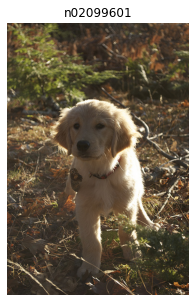

In [14]:
show_at(dsrc.train, 3)

In [15]:
dsrc.n_subsets

3

In [16]:
dls = dsrc.dataloaders(bs=bs, after_item=item_tfms, after_batch=batch_tfms, num_workers=0)

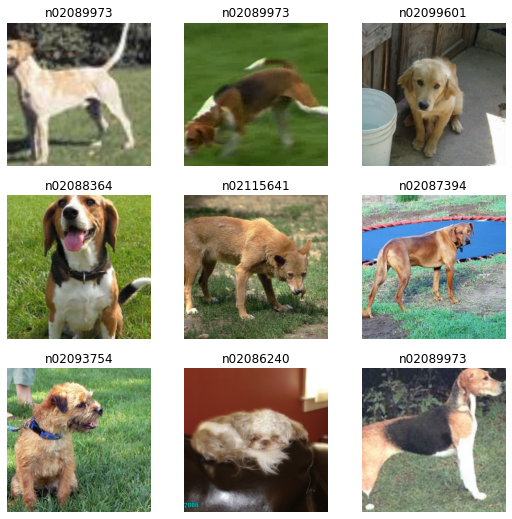

In [17]:
dls.show_batch()

In [18]:
dls.n_subsets

3

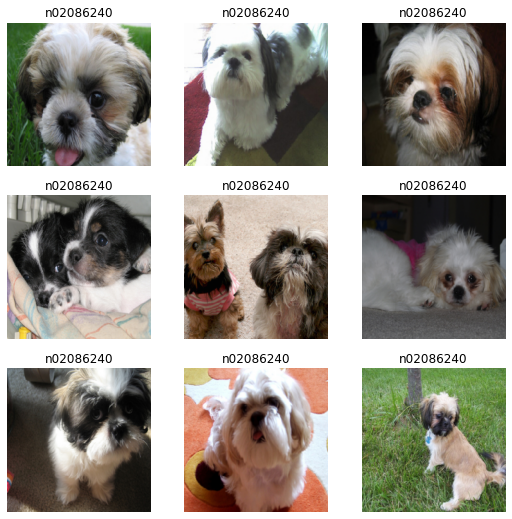

In [19]:
dls[2].show_batch()

In [20]:
learn = cnn_learner(dls, resnet34, pretrained=False, metrics=accuracy).to_fp16()

In [21]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,time
0,2.740069,2.164477,0.227147,01:53


In [22]:
learn.validate(ds_idx=2)

(#2) [2.1548187732696533,0.23161110281944275]

In [23]:
from sklearn.model_selection import StratifiedKFold

In [24]:
train_labels = L(dsrc.items).map(dsrc.tfms[1])

In [25]:
kf = StratifiedKFold(n_splits=5, shuffle=True)

In [26]:
n_splits = 10

In [27]:
import random
random.shuffle(train_imgs)

In [28]:
val_pct = []
tst_preds = []
skf = StratifiedKFold(n_splits=10, shuffle=True)

for _,val_idx in kf.split(np.array(train_imgs+tst_imgs), train_labels):
    splits = IndexSplitter(val_idx)
    split = splits(train_imgs)
    split_list = [split[0], split[1]]
    split_list.append(L(range(len(train_imgs), len(train_imgs)+len(tst_imgs))))
    dsrc = Datasets(train_imgs+tst_imgs, tfms=[[PILImage.create], [parent_label, Categorize]],
                    splits=split_list)
    dls = dsrc.dataloaders(bs=bs, after_item=item_tfms,after_batch=batch_tfms, num_workers=0)
    learn = cnn_learner(dls, resnet34, pretrained=False, metrics=accuracy)
    learn.fit_one_cycle(1)
    val_pct.append(learn.validate()[1])
    a,b = learn.get_preds(ds_idx=2)
    tst_preds.append(a)

epoch,train_loss,valid_loss,accuracy,time
0,2.710499,2.078844,0.228869,01:36


epoch,train_loss,valid_loss,accuracy,time
0,2.719194,2.129266,0.239290,01:37


epoch,train_loss,valid_loss,accuracy,time
0,2.727408,2.203796,0.226168,01:37


epoch,train_loss,valid_loss,accuracy,time
0,2.745934,2.205605,0.221536,01:52


epoch,train_loss,valid_loss,accuracy,time
0,2.695702,2.135504,0.222394,01:50


In [29]:
tst_preds_copy = tst_preds.copy()
accuracy(tst_preds_copy[0], b)

TensorBase(0.2492)

In [30]:
for i in tst_preds_copy:
    print(accuracy(i, b))

TensorBase(0.2492)
TensorBase(0.2375)
TensorBase(0.2443)
TensorBase(0.2240)
TensorBase(0.2268)


In [31]:
hat = tst_preds[0]
for pred in tst_preds[1:]:
    hat += pred

In [32]:
hat

tensor([[0.8433, 0.1627, 0.3123,  ..., 1.4508, 1.1657, 0.1820],
        [0.6451, 0.2792, 0.3848,  ..., 1.3980, 0.7174, 0.2235],
        [0.7922, 0.1304, 0.4973,  ..., 1.3530, 0.9363, 0.2027],
        ...,
        [0.1557, 1.0195, 0.4165,  ..., 0.1460, 0.1143, 0.7164],
        [0.8264, 0.2033, 0.7330,  ..., 0.6793, 0.4639, 0.6088],
        [0.1816, 0.7992, 0.2892,  ..., 0.0993, 0.0706, 0.9556]])

In [33]:
hat /= len(tst_preds)

In [34]:
accuracy(hat, b)

TensorBase(0.2767)

### Internal API

In [1]:
from fastai.vision.all import *
from fastdownload import download_url

In [2]:
url = 'https://upload.wikimedia.org/wikipedia/commons/a/a3/June_odd-eyed-cat.jpg'

In [3]:
download_url(url, 'cat.jpg')

Path('cat.jpg')

In [4]:
class PILImage(PILBase): pass

In [5]:
im = PILImage.create('cat.jpg')

In [6]:
class PILBase(Image.Image, metaclass=BypassNewMeta):
    _bypass_type=Image.Image
    _show_args= {'cmap':'virids'}
    _open_args={'mode':'RGB'}
    @classmethod
    def create(cls, fn:(Path,str,Tensor,ndarray,bytes), **kwargs)->None:
        if isinstance(fn,Tensor): fn = fn.numpy()
        if isinstance(fn,ndarray): return cls(Image.fromarray(fn))
        if isinstance(fn,bytes): fn = io.BytesIO(fn)
        return cls(load_image(fn, **merge(cls._open_args, kwargs)))
    def show(self, ctx=None, **kwargs):
        return show_image(self, ctx=ctx, **merge(self._show_args, kwargs))

<AxesSubplot:>

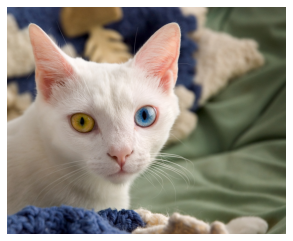

In [7]:
im.show()

In [8]:
block = TransformBlock(type_tfms=PILImage.create, batch_tfms=IntToFloatTensor)

In [9]:
PointBlock = TransformBlock(type_tfms=TensorPoint.create, item_tfms=PointScaler)

In [10]:
class myTensorPoint(TensorBase):
    _show_args = dict(s=10, marker='.', c='r')
    @classmethod
    def create(cls, t, img_size=None)->None:
        return cls(tensor(t).view(-1,2).float(), img_size=img_size)
    def show(self, ctx=None, **kwargs):
        if 'figsize' in kwargs: del kwargs['figsize']
        x = self.view(-1,2)
        ctx.scatter(x[:,0],x[:,1], **{**self._show_args, **kwargs})
        return ctx

In [11]:
im.shape

(1927, 2370)

In [12]:
pnts =[[1000, 100], [200,300]]

In [13]:
tps = myTensorPoint.create(pnts)

<AxesSubplot:>

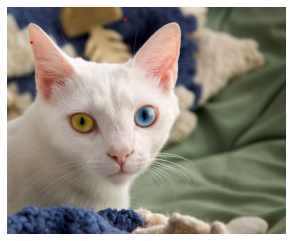

In [14]:
ctx = im.show()
tps.show(ctx=ctx)

In [15]:
myTensorPointCreate = Transform(myTensorPoint.create)

In [16]:
myTensorPointCreate.loss_func = MSELossFlat()

In [17]:
myTensorPoint.create = myTensorPointCreate

In [18]:
class myPointScaler(Transform):
    order = 1
    def __init__(self,do_scale=True, y_first=False):
        self.do_scale, self.y_first = do_scale, y_first
        
    def setups(self, dl):
        its = dl.do_items(0)
        for t in its:
            if isinstance(t, TensorPoint): self.c = t.numel()
    
    def _grab_sz(self, x):
        self.sz = [x.shape[-1], x.shape[-2]] if isinstance(x, Tensor) else x.size
        
    def encodes(self, x:(PILBase, TensorImageBase)): return self._grab_sz(x)
    def decodes(self, x:(PILBase, TensorImageBase)): return self._grab_sz(x)

In [19]:
tps.numel()

4

In [20]:
def _myScale_pnts(y, sz, do_scale=True, y_first=False):
    if y_first: y = y.flip(1)
    res = y * 2/tensor(sz).float() -1 if do_scale else y
    return TensorPoint(res, img_sz=sz)

In [21]:
tps

myTensorPoint([[1000.,  100.],
        [ 200.,  300.]])

In [22]:
_myScale_pnts(tps, 224)

TensorPoint([[ 7.9286, -0.1071],
        [ 0.7857,  1.6786]])

In [23]:
im.shape

(1927, 2370)

In [24]:
pnts = [[0,0],[2370,0],[0,1927],[2370,1927]]

In [25]:
tps = TensorPoint(pnts)

In [26]:
tps

TensorPoint([[   0,    0],
        [2370,    0],
        [   0, 1927],
        [2370, 1927]])

<AxesSubplot:>

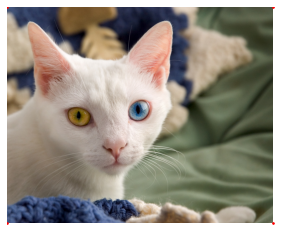

In [27]:
ax = im.show()
tps.show(ctx=ax)

In [28]:
s_pnts = [_myScale_pnts(tp, 224) for tp in tps]

In [29]:
s_pnts

[TensorPoint([-1., -1.]),
 TensorPoint([20.1607, -1.0000]),
 TensorPoint([-1.0000, 16.2054]),
 TensorPoint([20.1607, 16.2054])]

In [33]:
url2 = 'https://media.istockphoto.com/photos/maine-coon-cat-on-white-background-picture-id1031592516?k=20&m=1031592516&s=612x612&w=0&h=ISedoIwKmKUwmgmGXeuwl174eEAFuRAXORwVP2YxWuo='
download_url(url2, 'cat2.jpg')

Path('cat2.jpg')

In [35]:
im2 = PILImage.create('cat2.jpg')

In [36]:
im2.shape

(490, 612)

In [37]:
pnts2 = [[0,0],[612,0],[0,490],[612,490]]

In [38]:
tps2 = TensorPoint.create(pnts2)

<AxesSubplot:>

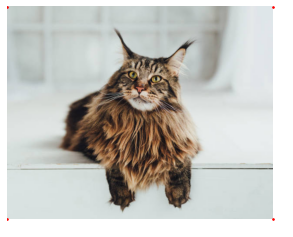

In [39]:
ax = im2.show()
tps2.show(ctx=ax)

In [40]:
[_myScale_pnts(tp, 224) for tp in tps2]

[TensorPoint([-1., -1.]),
 TensorPoint([ 4.4643, -1.0000]),
 TensorPoint([-1.0000,  3.3750]),
 TensorPoint([4.4643, 3.3750])]

In [41]:
def _myUnscale_pnts(y, sz): return TensorPoint((y+1)*tensor(sz).float()/2, img_size=sz)

In [42]:
s_pnts

[TensorPoint([-1., -1.]),
 TensorPoint([20.1607, -1.0000]),
 TensorPoint([-1.0000, 16.2054]),
 TensorPoint([20.1607, 16.2054])]

In [43]:
[_myUnscale_pnts(tp, 224) for tp in s_pnts]

[TensorPoint([0., 0.]),
 TensorPoint([2370.,    0.]),
 TensorPoint([   0., 1927.]),
 TensorPoint([2370., 1927.])]

In [45]:
myPointBlock = TransformBlock(type_tfms=myTensorPoint.create, item_tfms=myPointScaler)